# Random Forest
Best described as 'An ensemble of Decision Trees'<br>
Each tree is constructed from a Random subspace (rows and columns) of the original dataset to help make each one different<br>
What differs from regular decision trees, is that at each split point **a random set of the subspaces features are chosen to determine which feature to split on**.  This also makes the trees less correlated with one another<br>
Random subspaces are not contiguous, just a random sample.


Note: See [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for below code

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [5]:
RANDOM_SEED=42

## Decision Tree, what a random forest is composed of

## Regression
You can use random forest to predict a number

In [6]:
from sklearn.datasets import make_regression
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=7, noise=0.1, random_state=RANDOM_SEED)

from sklearn.ensemble import RandomForestRegressor

# define the model
clf = RandomForestRegressor(max_depth=5, random_state=0)

#fit it
clf.fit(X,y)

#predict
print(clf.predict([[0,1,2,3,4,5,6,7,8,9]]))

RandomForestRegressor(max_depth=5, random_state=0)

[83.59291184]


## Classification
You can use random forest to classify data

In [7]:
#make a dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=7, n_redundant=3, random_state=RANDOM_SEED,n_classes=5)

from sklearn.ensemble import RandomForestClassifier

# define the model
clf = RandomForestClassifier(max_depth=5, random_state=0)

#fit it
clf.fit(X,y)

#predict
print(clf.predict([[0,1,2,3,4,5,6,7,8,9]]))

RandomForestClassifier(max_depth=5, random_state=0)

[3]


## Out Of Bag Error (OOB)
Test each tree on the rows that it was not trained on, average these errors to get OOB error<BR>
Use this to tune your forest, for instance.  The number of trees you create, or the max_depth that each tree can be<br>
See [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html?highlight=randomforestclassifier)

In [36]:
# track errors here
# define dataset
X, y = make_classification(n_samples=500, n_features=25, n_clusters_per_class=1,n_informative=15,random_state=RANDOM_SEED)

error_rate={}
max_trees=100

# Range of `n_estimators` values to explore.
min_estimators = 12
max_estimators = 100

for i in list(range(min_estimators,max_estimators+1,5)):
    # define the model
    clf = RandomForestClassifier(n_estimators=i,max_depth=5, max_features="sqrt",random_state=RANDOM_SEED, oob_score=True)
    _=clf.fit(X,y)
    
    #get the error
    oob_error = 1 - clf.oob_score_
    error_rate[i]=oob_error

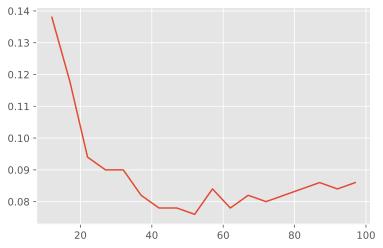

In [37]:
_=sns.lineplot(x=list(error_rate.keys()),y=list(error_rate.values()))

You can see that, for this dataset, any number of trees >40 doesn't help

## A word of caution, A random forest will only predict up (or down) to what it has seen in the past. So any outliers above or below will flatline at the max or min values that a forest can predict

This is in contrast to linear or logistic regression, which can predict on inputs that have never been seen before (anything along the hyperplane defined by it's slope and intercept)